In [1]:
import pandas as pd
import numpy as np
import os

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import Audio

%matplotlib inline

In [3]:
import librosa
import tensorflow as tf
from tensorflow import keras

2023-11-09 01:11:16.681514: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-09 01:11:17.312650: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


# 0. Functions

In [4]:
from sklearn import metrics

def get_metric_results(result):
    print(f'Loss is : {result[0] : .3f}')
    print(f'Categorical Accuracy is : {result[1] : .3f}')
    print(f'Precision score is : {result[2] : .3f}')
    print(f'Recall score is : {result[3] : .3f}')
    print(f'ROC AUC Score is : {result[4] : .3f}')
    print(f'F1 Score is : {result[5]}')

In [5]:
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):

    plt.figure(figsize = (6,6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    cm = np.round(cm,2)
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()


In [6]:
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize = (6,6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    cm = np.round(cm,2)
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

In [7]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_auc_score
from itertools import cycle

def auc_roc_plot(y_true, y_pred_prob, model):
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    for i in range(n_class):
        fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_pred_prob[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    plt.figure(figsize=(8, 6))
    colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'red', 'green', 'yellow'])
    for i, color in zip(range(n_class), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=2,
                 label=f'ROC area = {roc_auc[i] : .2f} for {emotion_from_idx[i]}')

    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC-AUC Curve for {} Model'.format(model))
    plt.legend(loc="lower right")
    plt.show()

# 1. Data Handeling

## 1.1. CREMA-D

In [8]:
crema_path = os.path.join('data', 'crema-d', 'AudioWAV')

In [9]:
os.path.join(crema_path, os.listdir(crema_path)[0])

'data/crema-d/AudioWAV/1010_IEO_HAP_HI.wav'

In [10]:
files_list = []
emotion_list = []

for pth in os.listdir(crema_path):
    data_path = os.path.join(crema_path, pth)
    files_list.append(data_path)
    
    emot_str = pth.split('_')[2]
    
    if emot_str == 'HAP':
        emotion_list.append('happy')
    elif emot_str == 'SAD':
        emotion_list.append('sad')
    elif emot_str == 'DIS':
        emotion_list.append('disgust')
    elif emot_str == 'ANG':
        emotion_list.append('anger')
    elif emot_str == 'FEA':
        emotion_list.append('fear')
    elif emot_str == 'NEU':
        emotion_list.append('neutral')
    else:
        emotion_list.append('unknown')

In [11]:
crema_df = pd.DataFrame({'data' : files_list, 'emotion' : emotion_list})
crema_df.head()

,data,emotion
0,data/crema-d/AudioWAV/1010_IEO_HAP_HI.wav,happy
1,data/crema-d/AudioWAV/1060_IEO_SAD_HI.wav,sad
2,data/crema-d/AudioWAV/1050_IOM_DIS_XX.wav,disgust
3,data/crema-d/AudioWAV/1039_IOM_SAD_XX.wav,sad
4,data/crema-d/AudioWAV/1081_TAI_ANG_XX.wav,anger


## 1.2. RAVDESS

In [12]:
ravdess_path = os.path.join('data', 'ravdess')

In [13]:
os.listdir(os.path.join(ravdess_path, os.listdir(ravdess_path)[0]))[0].split('-')[2]

'02'

(01 = neutral, 02 = calm, 03 = happy, 04 = sad, 05 = angry, 06 = fearful, 07 = disgust, 08 = surprised)

In [14]:
files_list = []
emotion_list = []

for actor in os.listdir(ravdess_path):
    actor_data_path = os.path.join(ravdess_path, actor)
    
    for pth in os.listdir(actor_data_path):
        data_path = os.path.join(actor_data_path, pth)
        files_list.append(data_path)
        
        emot_str = pth.split('-')[2]
        
        if emot_str == '01':
            emotion_list.append('neutral')
        elif emot_str == '02':
            emotion_list.append('calm')
        elif emot_str == '03':
            emotion_list.append('happy')
        elif emot_str == '04':
            emotion_list.append('sad')
        elif emot_str == '05':
            emotion_list.append('anger')
        elif emot_str == '06':
            emotion_list.append('fear')
        elif emot_str == '07':
            emotion_list.append('disgust')
        elif emot_str == '08':
            emotion_list.append('surprise')
        else:
            emotion_list.append('unknown')

In [15]:
ravdess_df = pd.DataFrame({'data' : files_list, 'emotion' : emotion_list})
ravdess_df.head()

,data,emotion
0,data/ravdess/Actor_07/03-01-02-01-01-02-07.wav,calm
1,data/ravdess/Actor_07/03-01-05-01-02-01-07.wav,anger
2,data/ravdess/Actor_07/03-01-02-02-02-02-07.wav,calm
3,data/ravdess/Actor_07/03-01-04-01-02-02-07.wav,sad
4,data/ravdess/Actor_07/03-01-02-02-01-01-07.wav,calm


## 1.3. SAVEE

In [16]:
savee_path = os.path.join('data', 'savee', 'ALL')

('a' = 'anger','d' = 'disgust','f' = 'fear','h' = 'happiness','n' = 'neutral','sa' = 'sadness','su' = 'surprise')

In [17]:
files_list = []
emotion_list = []

for pth in os.listdir(savee_path):
    data_path = os.path.join(savee_path, pth)
    files_list.append(data_path)
    
    emot_str = pth.split('_')[1][0:-6]
    
    if emot_str == 'h':
        emotion_list.append('happy')
    elif emot_str == 'sa':
        emotion_list.append('sad')
    elif emot_str == 'd':
        emotion_list.append('disgust')
    elif emot_str == 'a':
        emotion_list.append('anger')
    elif emot_str == 'f':
        emotion_list.append('fear')
    elif emot_str == 'n':
        emotion_list.append('neutral')
    elif emot_str == 'su':
        emotion_list.append('surprise')
    else:
        emotion_list.append('unknown')

In [18]:
savee_df = pd.DataFrame({'data' : files_list, 'emotion' : emotion_list})
savee_df.head()

,data,emotion
0,data/savee/ALL/KL_h01.wav,happy
1,data/savee/ALL/JE_d13.wav,disgust
2,data/savee/ALL/JE_a04.wav,anger
3,data/savee/ALL/KL_sa04.wav,sad
4,data/savee/ALL/JK_su11.wav,surprise


## 1.4. TESS

In [19]:
tess_path = os.path.join('data', 'tess')

In [20]:
os.listdir(tess_path)[0].split('_')[1]

'disgust'

In [21]:
files_list = []
emotion_list = []

for emotion in os.listdir(tess_path):
    emotion_pth = os.path.join(tess_path, emotion)
    
    for pth in os.listdir(emotion_pth):
        data_path = os.path.join(emotion_pth, pth)
        files_list.append(data_path)
        
        emot_str = emotion.split('_')[1]
        
        if emot_str == 'neutral':
            emotion_list.append('neutral')
        elif emot_str == 'happy':
            emotion_list.append('happy')
        elif emot_str == 'sad':
            emotion_list.append('sad')
        elif emot_str == 'angry':
            emotion_list.append('anger')
        elif emot_str == 'fear':
            emotion_list.append('fear')
        elif emot_str == 'disgust':
            emotion_list.append('disgust')
        elif emot_str == 'surprise':
            emotion_list.append('surprise')
        else:
            emotion_list.append('unknown')

In [22]:
tess_df = pd.DataFrame({'data' : files_list, 'emotion' : emotion_list})
tess_df.head()

,data,emotion
0,data/tess/OAF_disgust/OAF_gun_disgust.wav,disgust
1,data/tess/OAF_disgust/OAF_red_disgust.wav,disgust
2,data/tess/OAF_disgust/OAF_void_disgust.wav,disgust
3,data/tess/OAF_disgust/OAF_chain_disgust.wav,disgust
4,data/tess/OAF_disgust/OAF_yes_disgust.wav,disgust


## 1.5. Compilation

In [23]:
df = pd.concat([crema_df, ravdess_df, savee_df, tess_df], axis = 0)
df.head()

,data,emotion
0,data/crema-d/AudioWAV/1010_IEO_HAP_HI.wav,happy
1,data/crema-d/AudioWAV/1060_IEO_SAD_HI.wav,sad
2,data/crema-d/AudioWAV/1050_IOM_DIS_XX.wav,disgust
3,data/crema-d/AudioWAV/1039_IOM_SAD_XX.wav,sad
4,data/crema-d/AudioWAV/1081_TAI_ANG_XX.wav,anger


In [24]:
df = df.sample(frac = 1)
df.head()

,data,emotion
1413,data/tess/YAF_happy/YAF_deep_happy.wav,happy
5430,data/crema-d/AudioWAV/1056_IWW_ANG_XX.wav,anger
2437,data/crema-d/AudioWAV/1004_ITS_ANG_XX.wav,anger
59,data/savee/ALL/DC_f11.wav,fear
1681,data/tess/YAF_sad/YAF_rough_sad.wav,sad


In [25]:
df_path = os.path.join('data', "data.csv")

In [26]:
# df.to_csv(df_path, index=False)

## 1.6. Data Loading

In [27]:
df_path = os.path.join('data', "data.csv")

In [28]:
df = pd.read_csv(df_path)
df.head()

,data,emotion
0,data/crema-d/AudioWAV/1037_ITS_ANG_XX.wav,anger
1,data/crema-d/AudioWAV/1072_TIE_SAD_XX.wav,sad
2,data/crema-d/AudioWAV/1055_TSI_DIS_XX.wav,disgust
3,data/crema-d/AudioWAV/1067_IWW_DIS_XX.wav,disgust
4,data/crema-d/AudioWAV/1012_MTI_DIS_XX.wav,disgust


In [29]:
df.emotion.unique()

array(['anger', 'sad', 'disgust', 'neutral', 'happy', 'fear'],
      dtype=object)

In [30]:
df.isnull().sum()

data       0
emotion    0
dtype: int64

In [31]:
df.emotion.value_counts()

emotion
anger      1923
sad        1923
disgust    1923
happy      1923
fear       1923
neutral    1703
Name: count, dtype: int64

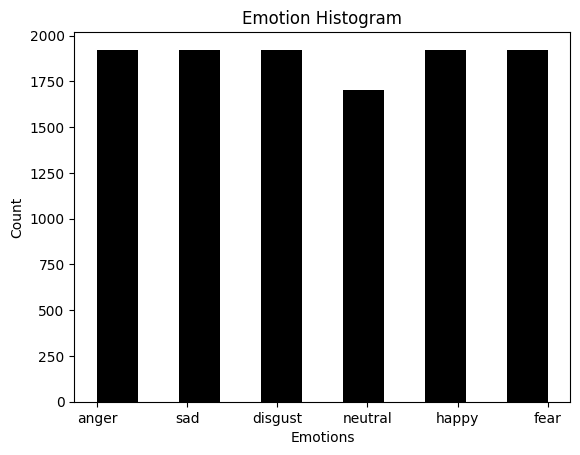

In [32]:
plt.title('Emotion Histogram')
plt.hist(df.emotion, color='black', bins=11)
plt.ylabel('Count')
plt.xlabel('Emotions')
plt.show()

# 2. Data Processing

## 2.1. Data Augmentation

In [33]:
np.array(df.data)[50]

'data/savee/ALL/KL_n01.wav'

In [34]:
path = np.array(df.data)[50]
data_sample, sample_rate = librosa.load(path)
np.array(df.emotion)[50]

'neutral'

In [35]:
Audio(path)

In [36]:
from audiomentations import Compose, TimeStretch, PitchShift, AddGaussianNoise

def augmentation(audio):
    augment = Compose([
        TimeStretch(min_rate=0.8, max_rate=1.2),
        PitchShift(min_semitones=-1, max_semitones=1),
        AddGaussianNoise(min_amplitude=0.0001, max_amplitude=0.0005),
    ])
    
    augmented_audio = augment(samples=audio, sample_rate=sample_rate)
    return augmented_audio

In [37]:
x = augmentation(data_sample)
print(np.array(df.emotion)[50])
Audio(x, rate=sample_rate)

neutral


## 2.2. Feature Extraction

In [38]:
def extract_features(audio_data, sample_rate):    
    mfccs = librosa.feature.mfcc(
        y = audio_data, sr = sample_rate, n_mfcc=40
    )
    chroma = librosa.feature.chroma_stft(
        y = audio_data, sr = sample_rate
    )
    spectral_centroid = librosa.feature.spectral_centroid(
        y = audio_data, sr = sample_rate
    )
    spectral_contrast = librosa.feature.spectral_contrast(
        y = audio_data, sr = sample_rate
    )
    zcr = librosa.feature.zero_crossing_rate(
        y = audio_data
    )
    rmse = librosa.feature.rms(
        y = audio_data
    )
    
    mean = librosa.feature.spectral_rolloff(
        y = audio_data, sr = sample_rate
    )
    std = librosa.feature.spectral_bandwidth(
        y = audio_data, sr = sample_rate
    )
    skewness = librosa.feature.spectral_contrast(
        y = audio_data, sr = sample_rate
    )
    kurtosis = librosa.feature.poly_features(
        y = audio_data, sr = sample_rate
    )
    
    ans = np.concatenate((mfccs, chroma, spectral_centroid, spectral_contrast, zcr, rmse, mean, std, skewness, kurtosis), axis=0)
    
    return ans.T

In [39]:
extract_features(data_sample, sample_rate).shape

(155, 73)

- Row : Timeframe
- Column : Features

In [40]:
df.shape[0]

11318

## 2.3. Data Processing

In [41]:
def data_processing(path):
    data, sample_rate = librosa.load(path, duration=3, offset=0.5)
    
    result = []
    for i in range(5):
        augmented_data = augmentation(data)
        features = extract_features(augmented_data, sample_rate)
        result.append(features)
    
    return np.array(result)

In [42]:
data_processing(df.iloc[1011, 0])[0].shape

(52, 73)

In [43]:
def create_features_file():
    i = 0
    end = len(df)
    feature_path = os.path.join('data', 'feature')
    
    split_path = ''

    while i < end:
        features = data_processing(df.iloc[i, 0])        
        j = 0
        for feature in features:
            file_name = 'np_' + str(i) + '_' + str(j) + '_' + df.iloc[i, 1] + '.npy'
            
            if i < len(df) * 0.6:
                split_path = 'train'
            elif i < len(df) * 0.8:
                split_path = 'val'
            else:
                split_path = 'test'

            feature_save_path = os.path.join(feature_path, split_path, file_name)
            np.save(feature_save_path, feature)
            j += 1
            
        i += 1
        print(i, '/', end, '-> DONE')

In [44]:
# create_features_file()

# 3. Tensorflow Dataset

In [45]:
feature_dir = os.path.join('data', 'feature')

i = 0
for x in os.listdir(os.path.join(feature_dir, 'train')):
    print(x.split('_')[-1][0:-4], end=', ')
    
    if i > 5:
        break
    i += 1

neutral, fear, anger, anger, fear, disgust, sad, 

In [46]:
emotion_class = {
    'fear' : 0, 'anger' : 1, 'happy' : 2, 'disgust' : 3, 'sad' : 4, 'neutral' : 5
}

emotion_from_idx = {
    0 : 'fear', 1 : 'anger', 2 : 'happy', 3 : 'disgust', 4 : 'sad', 5 : 'neutral'
}

In [47]:
def get_generator(pth_str, n_rows, n_cols):
    curr_dir = os.path.join(feature_dir, pth_str)
    
    def generator():
        for npy_file in os.listdir(curr_dir):
            npy_pth = os.path.join(curr_dir, npy_file)

            label = npy_file.split('_')[-1][0:-4]

            data = np.load(npy_pth)            
            data = np.pad(data, ((0, n_rows - data.shape[0]), (0, 0)), 'constant', constant_values=0)

            yield data, emotion_class[label]
    
    return generator

In [48]:
def get_max_sequence():
    n_row = 0
    for split in os.listdir(feature_dir):
        split_dir = os.path.join(feature_dir, split)
        for x in os.listdir(split_dir):
            x_path = os.path.join(split_dir, x)
            data = np.load(x_path)
            n_row = max(data.shape[0], n_row)
            print(x)
    
    return n_row

In [49]:
n_row = 130
n_col = 73
n_class = 6
# n_row = get_max_sequence()
print('({}, {})'.format(n_row, n_col))

(130, 73)


In [50]:
train_generator = get_generator('train', n_row, n_col)
val_generator = get_generator('val', n_row, n_col)
test_generator = get_generator('test', n_row, n_col)

train_ds = tf.data.Dataset.from_generator(
    train_generator,
    output_types=(tf.float64, tf.int32),
    output_shapes=((n_row, n_col), ())
)
val_ds = tf.data.Dataset.from_generator(
    val_generator,
    output_types=(tf.float64, tf.int32),
    output_shapes=((n_row, n_col), ())
)
test_ds = tf.data.Dataset.from_generator(
    test_generator,
    output_types=(tf.float64, tf.int32),
    output_shapes=((n_row, n_col), ())
)

2023-11-09 01:11:21.932222: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-09 01:11:21.955315: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-09 01:11:21.955531: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [51]:
for file in train_ds.take(1):
    print(file)

(<tf.Tensor: shape=(130, 73), dtype=float64, numpy=
array([[-4.99201202e+02,  1.19229553e+02,  3.43022003e+01, ...,
         1.37792921e+01, -1.16341053e-05,  9.16850589e-02],
       [-4.72067627e+02,  1.27690353e+02,  3.42954865e+01, ...,
         1.78345426e+01, -1.62765920e-05,  1.27233028e-01],
       [-4.70838715e+02,  1.27672180e+02,  3.76685410e+01, ...,
         6.59218835e+01, -1.61807540e-05,  1.26674034e-01],
       ...,
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00]])>, <tf.Tensor: shape=(), dtype=int32, numpy=5>)


## 3.1. One Hot Encoding

In [52]:
def one_hot_encoding(datapoint, label):
    num_classes = len(emotion_class)

    one_hot_label = tf.one_hot(label, depth=num_classes)
    
    return (datapoint, one_hot_label)

In [53]:
train_ds = train_ds.map(one_hot_encoding)
val_ds = val_ds.map(one_hot_encoding)
test_ds = test_ds.map(one_hot_encoding)

## 3.2. Batching and Optimization

In [54]:
batch_size = 128

In [55]:
train_ds = train_ds.batch(batch_size)
val_ds = val_ds.batch(batch_size)
test_ds = test_ds.batch(batch_size)

In [56]:
for file in train_ds.take(5):
    print(tf.TensorSpec.from_tensor(file[0]).shape)

(128, 130, 73)
(128, 130, 73)
(128, 130, 73)
(128, 130, 73)
(128, 130, 73)


## 3.4. Shuffle

In [57]:
train_ds = train_ds.shuffle(12).cache()
val_ds = val_ds.prefetch(tf.data.AUTOTUNE)

# 4. Proposed Model

In [58]:
def make_modified_model(input_shape, num_classes):
    input_layer = keras.layers.Input(input_shape)
    
    lstm1 = keras.layers.LSTM(64, return_sequences=True)(input_layer)
    lstm1 = keras.layers.BatchNormalization()(lstm1)
    
    conv1 = keras.layers.Conv1D(filters=64, kernel_size=3, padding="same")(input_layer)
    conv1 = keras.layers.BatchNormalization()(conv1)
    conv1 = keras.layers.ReLU()(conv1)
    
    concat1 = keras.layers.concatenate([lstm1, conv1])
    
    lstm2 = keras.layers.LSTM(128, return_sequences=True)(concat1)
    lstm2 = keras.layers.BatchNormalization()(lstm2)
    
    conv2 = keras.layers.Conv1D(filters=128, kernel_size=3, padding="same")(concat1)
    conv2 = keras.layers.BatchNormalization()(conv2)
    conv2 = keras.layers.ReLU()(conv2)
    
    concat2 = keras.layers.concatenate([lstm2, conv2])
    
    lstm3 = keras.layers.LSTM(256, return_sequences=False)(concat2)
    lstm3 = keras.layers.BatchNormalization()(lstm3)
    
    conv3 = keras.layers.Conv1D(filters=256, kernel_size=3, padding="same")(concat2)
    conv3 = keras.layers.BatchNormalization()(conv3)
    conv3 = keras.layers.ReLU()(conv3)
    conv3 = keras.layers.GlobalAveragePooling1D()(conv3)
    
    concat3 = keras.layers.concatenate([lstm3, conv3])
    
    dense1 = keras.layers.Dense(1024, activation='relu')(concat3)
    drop1 = keras.layers.Dropout(0.5)(dense1)
    
    dense2 = keras.layers.Dense(1024, activation='relu')(drop1)
    drop2 = keras.layers.Dropout(0.5)(dense2)

    output_layer = keras.layers.Dense(num_classes, activation="softmax")(drop2)

    return keras.models.Model(inputs=input_layer, outputs=output_layer)

In [59]:
modified_model = make_modified_model((n_row, n_col), n_class)

modified_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 130, 73)]            0         []                            
                                                                                                  
 conv1d (Conv1D)             (None, 130, 64)              14080     ['input_1[0][0]']             
                                                                                                  
 lstm (LSTM)                 (None, 130, 64)              35328     ['input_1[0][0]']             
                                                                                                  
 batch_normalization_1 (Bat  (None, 130, 64)              256       ['conv1d[0][0]']              
 chNormalization)                                                                             

In [60]:
METRICS = [
    keras.metrics.CategoricalAccuracy(name = 'acc'),
    keras.metrics.Precision(name = 'prec'),
    keras.metrics.Recall(name = 'recall'),
    keras.metrics.AUC(name = 'AUC'),
    keras.metrics.F1Score(name = 'F1'),
]

In [61]:
modified_model.compile(
      optimizer=keras.optimizers.Adam(learning_rate=0.001),
      loss=tf.keras.losses.CategoricalCrossentropy(),
      metrics=METRICS
)

In [62]:
from datetime import datetime
logdir = os.path.join('logs','fit', datetime.now().strftime("%Y%m%d-%H%M%S"))

tensorboard_callback = keras.callbacks.TensorBoard(log_dir=logdir)

checkpoint = keras.callbacks.ModelCheckpoint(
    filepath=os.path.join('weights', 'best_model.h5'),
    monitor='val_loss',
    save_best_only=True,
    mode='min'
)

In [63]:
modified_model.evaluate(test_ds, verbose=1)

2023-11-09 01:11:25.983495: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600
2023-11-09 01:11:26.500583: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


89/89 [==============================] - 9s 63ms/step - loss: 32.6838 - acc: 0.1681 - prec: 0.1682 - recall: 0.1675 - AUC: 0.4890 - F1: 0.0490


[32.68379211425781,
 0.1680954545736313,
 0.1682201474905014,
 0.1674768030643463,
 0.489047110080719,
 array([0.00567913, 0.        , 0.        , 0.        , 0.28808025,
        0.        ], dtype=float32)]

In [64]:
# hist = modified_model.fit(
#     train_ds, 
#     epochs=100, 
#     verbose=1, 
#     validation_data=val_ds, 
#     callbacks=[checkpoint]
# )

## 4.1. Model Save

In [65]:
save_link = os.path.join('saved_model', 'modified_model.keras')
# modified_model.save(save_link)

In [66]:
modified_model = tf.keras.models.load_model(save_link)

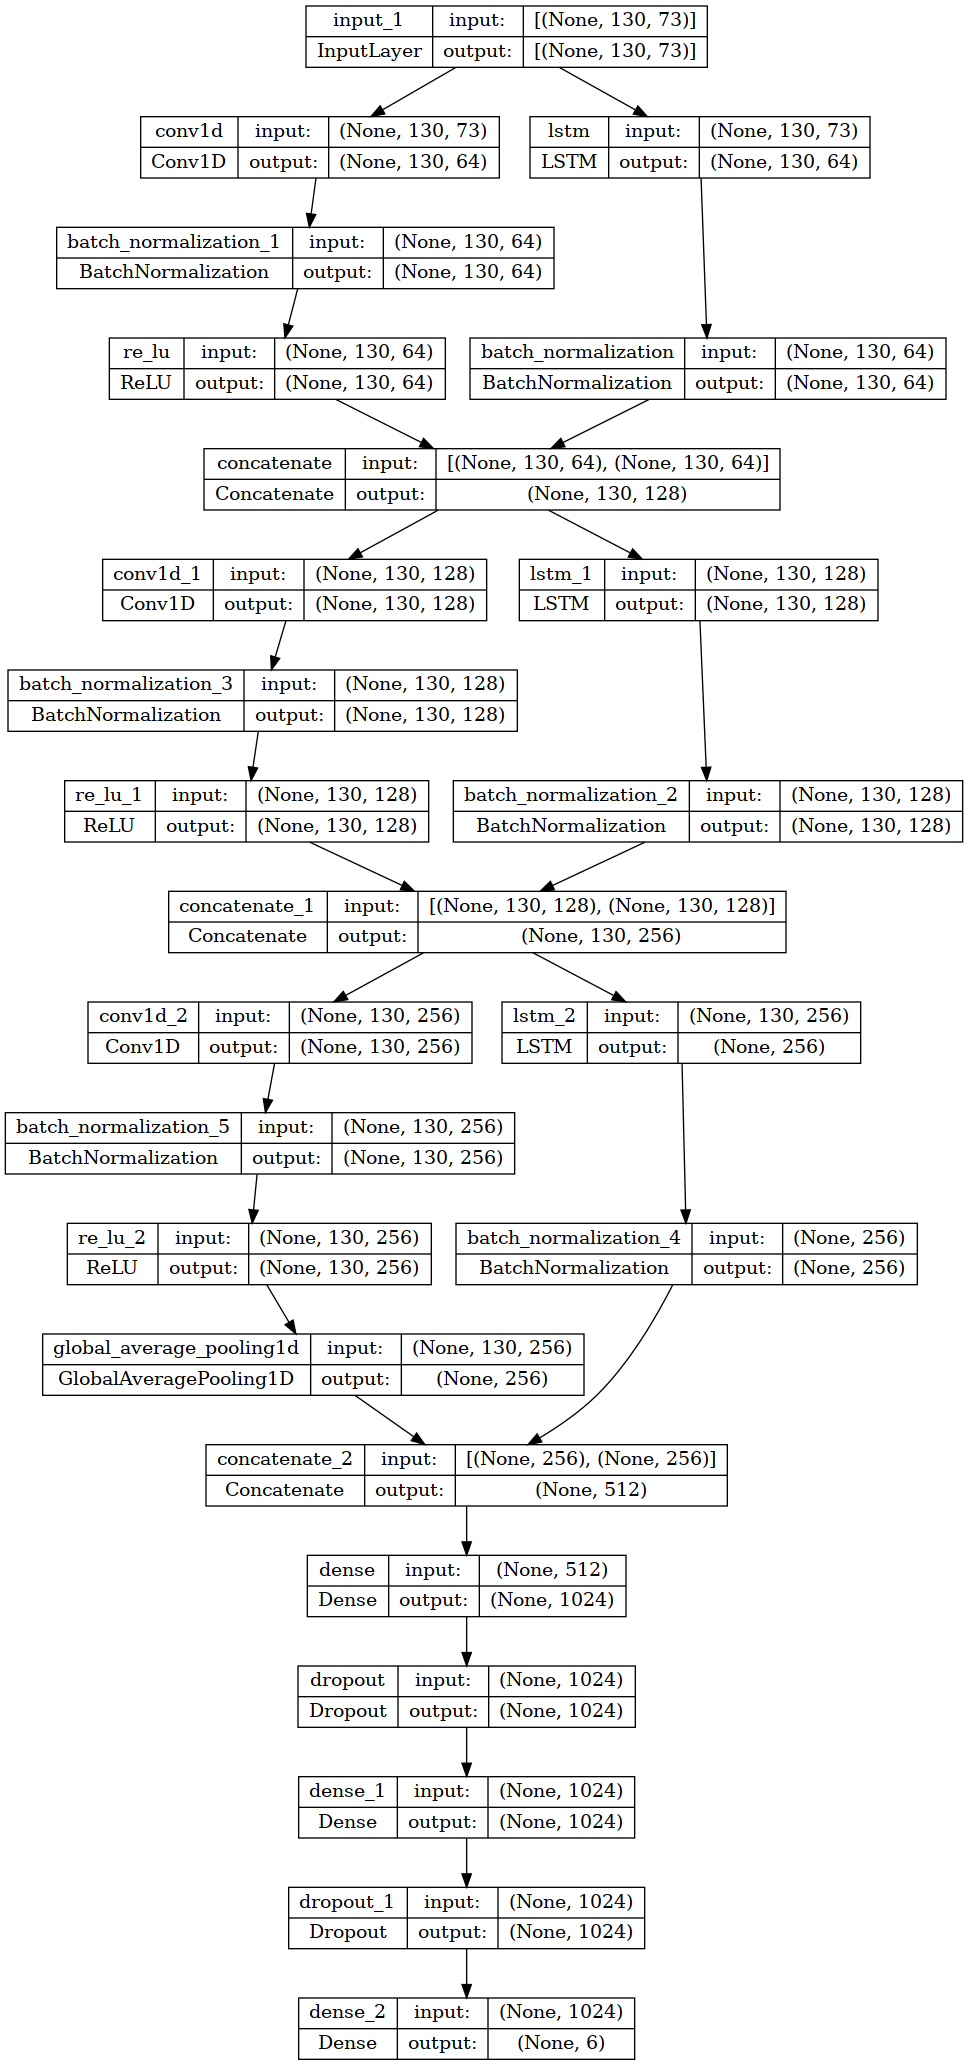

In [67]:
tf.keras.utils.plot_model(modified_model, to_file='model.png', show_shapes=True, expand_nested=True)

In [68]:
result = modified_model.evaluate(test_ds)

89/89 [==============================] - 7s 63ms/step - loss: 1.0220 - acc: 0.6231 - prec: 0.7049 - recall: 0.5474 - AUC: 0.9032 - F1: 0.6206


2023-11-09 01:11:41.051891: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous recv item cancelled. Key hash: 1473789885358075295


## 4.2. Plots

In [69]:
y_true_list = []
y_pred_list = []

for batch in test_ds:
    x_batch, y_batch = batch

    y_pred_batch = modified_model.predict(x_batch)

    y_true_list.append(y_batch)
    y_pred_list.append(y_pred_batch)

y_true = np.concatenate(y_true_list, axis=0)
y_pred_prob = np.concatenate(y_pred_list, axis=0)

2/2 [==============================] - 1s 82ms/step


In [70]:
get_metric_results(result)

Loss is :  1.022
Categorical Accuracy is :  0.623
Precision score is :  0.705
Recall score is :  0.547
ROC AUC Score is :  0.903
F1 Score is : [0.5247649  0.69646394 0.61325186 0.6091627  0.62388265 0.6561514 ]


In [71]:
print('\nClassification Report:\n\n', metrics.classification_report(np.argmax(y_true, axis=1), np.argmax(y_pred_prob, axis=1)))


Classification Report:

               precision    recall  f1-score   support

           0       0.74      0.41      0.52      2065
           1       0.77      0.63      0.70      1945
           2       0.55      0.70      0.61      1875
           3       0.75      0.51      0.61      1885
           4       0.55      0.71      0.62      1905
           5       0.54      0.82      0.66      1640

    accuracy                           0.62     11315
   macro avg       0.65      0.63      0.62     11315
weighted avg       0.66      0.62      0.62     11315



### 4.2.1. Confusion Matrix

In [72]:
from sklearn.metrics import confusion_matrix, classification_report

cm = confusion_matrix(np.argmax(y_true, axis=1), np.argmax(y_pred_prob, axis=1))
cm

array([[ 837,   48,  393,   49,  494,  244],
       [  84, 1231,  407,   90,   10,  123],
       [  97,  110, 1305,   68,  115,  180],
       [  40,  186,  169,  964,  310,  216],
       [  58,    5,   47,   68, 1361,  366],
       [   9,   10,   60,   41,  168, 1352]])

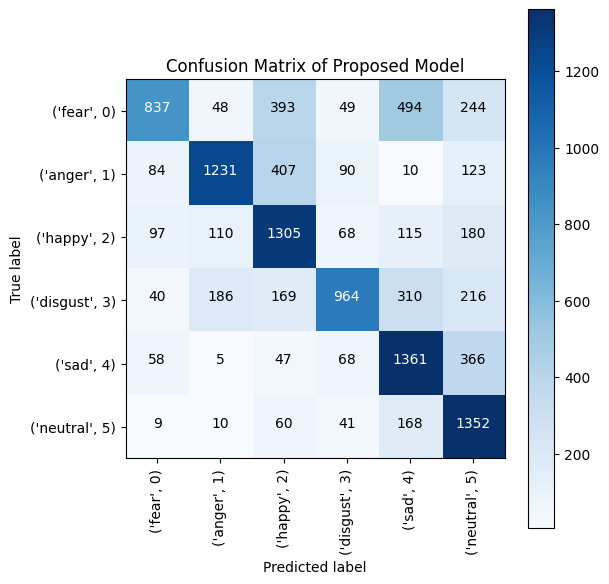

In [73]:
plot_confusion_matrix(cm, classes = list(emotion_class.items()), normalize=False, title='Confusion Matrix of Proposed Model')

### 4.2.2. AOC-ROC

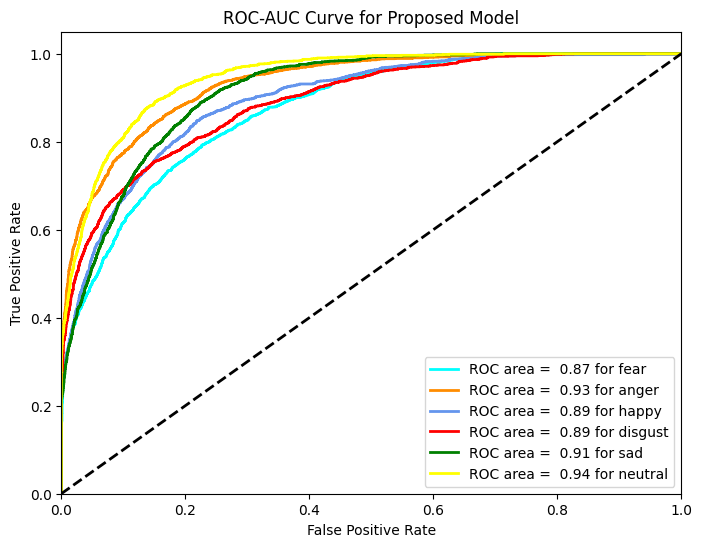

In [74]:
auc_roc_plot(y_true, y_pred_prob, 'Proposed')

# 5. VGG16 Model

In [75]:
def make_vgg_model(input_shape, num_classes):
    input_layer = keras.layers.Input(input_shape)
    
    conv1 = keras.layers.Conv1D(filters=64, kernel_size=3, padding="same", activation='relu')(input_layer)
    conv1 = keras.layers.Conv1D(filters=64, kernel_size=3, padding="same", activation='relu')(conv1)
    conv1 = keras.layers.MaxPooling1D(pool_size=2)(conv1)

    conv1 = keras.layers.Conv1D(filters=128, kernel_size=3, padding="same", activation='relu')(conv1)
    conv1 = keras.layers.Conv1D(filters=128, kernel_size=3, padding="same", activation='relu')(conv1)
    conv1 = keras.layers.MaxPooling1D(pool_size=2)(conv1)

    conv1 = keras.layers.Conv1D(filters=256, kernel_size=3, padding="same", activation='relu')(conv1)
    conv1 = keras.layers.Conv1D(filters=256, kernel_size=3, padding="same", activation='relu')(conv1)
    conv1 = keras.layers.MaxPooling1D(pool_size=2)(conv1)

    conv1 = keras.layers.Conv1D(filters=512, kernel_size=3, padding="same", activation='relu')(conv1)
    conv1 = keras.layers.Conv1D(filters=512, kernel_size=3, padding="same", activation='relu')(conv1)
    conv1 = keras.layers.MaxPooling1D(pool_size=2)(conv1)
    
    conv1 = keras.layers.Conv1D(filters=512, kernel_size=3, padding="same", activation='relu')(conv1)
    conv1 = keras.layers.Conv1D(filters=512, kernel_size=3, padding="same", activation='relu')(conv1)
    conv1 = keras.layers.MaxPooling1D(pool_size=2)(conv1)
    
    flat = keras.layers.Flatten()(conv1)
    
    dense1 = keras.layers.Dense(4096, activation='relu')(flat)
    drop1 = keras.layers.Dropout(0.6)(dense1)
    
    dense2 = keras.layers.Dense(4096, activation='relu')(drop1)
    drop2 = keras.layers.Dropout(0.6)(dense2)
    
    dense3 = keras.layers.Dense(4096, activation='relu')(drop2)
    drop3 = keras.layers.Dropout(0.6)(dense3)

    output_layer = keras.layers.Dense(num_classes, activation="softmax")(drop3)

    return keras.models.Model(inputs=input_layer, outputs=output_layer)

In [76]:
vgg_model = make_vgg_model((n_row, n_col), n_class)

vgg_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 130, 73)]         0         
                                                                 
 conv1d_3 (Conv1D)           (None, 130, 64)           14080     
                                                                 
 conv1d_4 (Conv1D)           (None, 130, 64)           12352     
                                                                 
 max_pooling1d (MaxPooling1  (None, 65, 64)            0         
 D)                                                              
                                                                 
 conv1d_5 (Conv1D)           (None, 65, 128)           24704     
                                                                 
 conv1d_6 (Conv1D)           (None, 65, 128)           49280     
                                                           

In [77]:
METRICS = [
    keras.metrics.CategoricalAccuracy(name = 'acc'),
    keras.metrics.Precision(name = 'prec'),
    keras.metrics.Recall(name = 'recall'),
    keras.metrics.AUC(name = 'AUC'),
    keras.metrics.F1Score(name = 'F1'),
]

In [78]:
vgg_model.compile(
      optimizer=keras.optimizers.Adam(learning_rate=0.001),
      loss=tf.keras.losses.CategoricalCrossentropy(),
      metrics=METRICS
)

In [79]:
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath=os.path.join('weights', 'best_model.h5'),
    monitor='val_loss',
    save_best_only=True,
    mode='min'
)

In [80]:
vgg_model.evaluate(test_ds, verbose=1)

89/89 [==============================] - 7s 65ms/step - loss: 12.9465 - acc: 0.1684 - prec: 0.1684 - recall: 0.1684 - AUC: 0.5003 - F1: 0.0480


2023-11-09 01:11:58.511970: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous recv item cancelled. Key hash: 2132549140981843531


[12.946525573730469,
 0.16836057603359222,
 0.16836057603359222,
 0.16836057603359222,
 0.5002809166908264,
 array([0.       , 0.       , 0.       , 0.       , 0.2881997, 0.       ],
       dtype=float32)]

In [81]:
# hist = vgg_model.fit(train_ds, epochs=100, verbose=1, validation_data=val_ds, callbacks=[checkpoint])

# 5.1. Model Saving

In [82]:
save_link = os.path.join('saved_model', 'vgg16.keras')
# vgg_model.save(save_link)

In [83]:
vgg_model = tf.keras.models.load_model(save_link)

In [84]:
result = vgg_model.evaluate(test_ds)

89/89 [==============================] - 6s 63ms/step - loss: 1.1393 - acc: 0.5580 - prec: 0.7122 - recall: 0.4066 - AUC: 0.8661 - F1: 0.5590


2023-11-09 01:12:13.919463: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous recv item cancelled. Key hash: 14173896153188548211


# 5.2. Plots

In [85]:
y_true_list = []
y_pred_list = []

for batch in test_ds:
    x_batch, y_batch = batch

    y_pred_batch = vgg_model.predict(x_batch)

    y_true_list.append(y_batch)
    y_pred_list.append(y_pred_batch)

y_true = np.concatenate(y_true_list, axis=0)
y_pred_prob = np.concatenate(y_pred_list, axis=0)

2/2 [==============================] - 0s 249ms/step


In [86]:
get_metric_results(result)

Loss is :  1.139
Categorical Accuracy is :  0.558
Precision score is :  0.712
Recall score is :  0.407
ROC AUC Score is :  0.866
F1 Score is : [0.498712   0.6358713  0.5264644  0.51736224 0.5790139  0.5966229 ]


In [87]:
print('\nClassification Report:\n\n', metrics.classification_report(np.argmax(y_true, axis=1), np.argmax(y_pred_prob, axis=1)))


Classification Report:

               precision    recall  f1-score   support

           0       0.53      0.47      0.50      2065
           1       0.84      0.51      0.64      1945
           2       0.47      0.60      0.53      1875
           3       0.65      0.43      0.52      1885
           4       0.56      0.60      0.58      1905
           5       0.48      0.78      0.60      1640

    accuracy                           0.56     11315
   macro avg       0.59      0.56      0.56     11315
weighted avg       0.59      0.56      0.56     11315



### 5.2.1. Confusion Matrix

In [88]:
from sklearn.metrics import confusion_matrix, classification_report

cm = confusion_matrix(np.argmax(y_true, axis=1), np.argmax(y_pred_prob, axis=1))

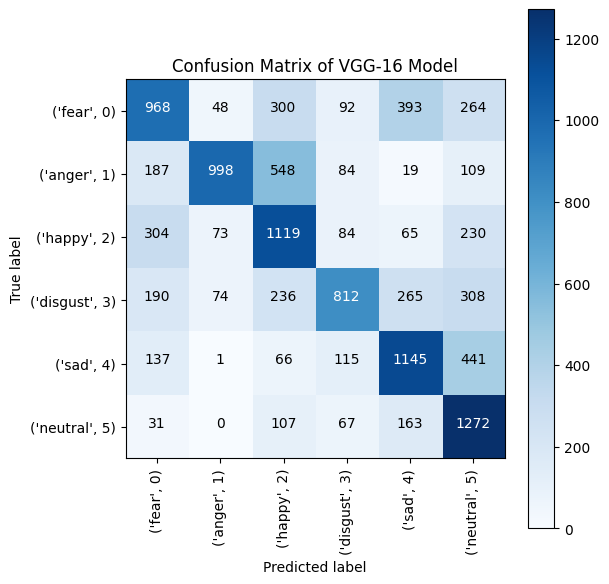

In [89]:
plot_confusion_matrix(cm, classes = list(emotion_class.items()), normalize=False, title='Confusion Matrix of VGG-16 Model')

### 5.2.2. AUC-ROC

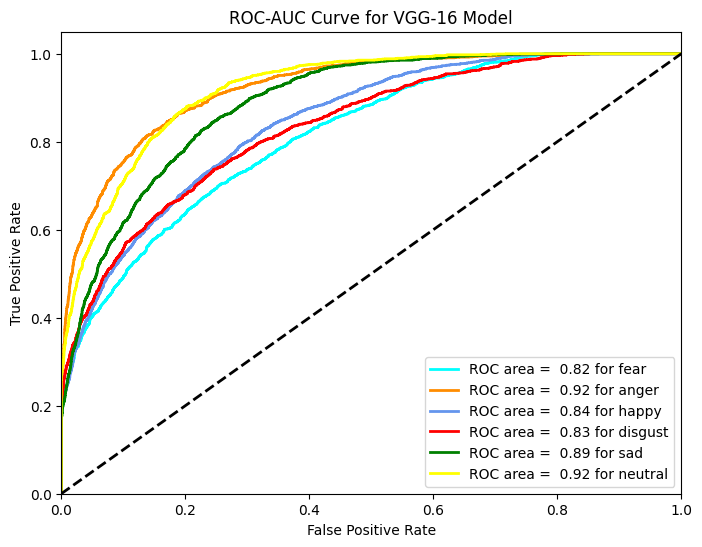

In [90]:
auc_roc_plot(y_true, y_pred_prob, 'VGG-16')

# 6. LSTM model

In [91]:
def make_lstm_model(input_shape, num_classes):
    input_layer = keras.layers.Input(input_shape)
    
    lstm1 = keras.layers.Bidirectional(
        keras.layers.LSTM(128, return_sequences=True)
    )(input_layer)
    
    lstm2 = keras.layers.Bidirectional(
        keras.layers.LSTM(256, return_sequences=False)
    )(lstm1)
    
    dense1 = keras.layers.Dense(128, activation='relu')(lstm2)
    drop1 = keras.layers.Dropout(0.6)(dense1)
    
    dense2 = keras.layers.Dense(256, activation='relu')(drop1)
    drop2 = keras.layers.Dropout(0.6)(dense2)
    
    dense3 = keras.layers.Dense(512, activation='relu')(drop2)
    drop3 = keras.layers.Dropout(0.6)(dense3)

    output_layer = keras.layers.Dense(num_classes, activation="softmax")(drop3)

    return keras.models.Model(inputs=input_layer, outputs=output_layer)

In [92]:
lstm_model = make_lstm_model((n_row, n_col), n_class)

lstm_model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 130, 73)]         0         
                                                                 
 bidirectional (Bidirection  (None, 130, 256)          206848    
 al)                                                             
                                                                 
 bidirectional_1 (Bidirecti  (None, 512)               1050624   
 onal)                                                           
                                                                 
 dense_7 (Dense)             (None, 128)               65664     
                                                                 
 dropout_5 (Dropout)         (None, 128)               0         
                                                                 
 dense_8 (Dense)             (None, 256)               3302

In [93]:
METRICS = [
    keras.metrics.CategoricalAccuracy(name = 'acc'),
    keras.metrics.Precision(name = 'prec'),
    keras.metrics.Recall(name = 'recall'),
    keras.metrics.AUC(name = 'AUC'),
    keras.metrics.F1Score(name = 'F1'),
]

In [94]:
lstm_model.compile(
      optimizer=keras.optimizers.Adam(learning_rate=0.001),
      loss=tf.keras.losses.CategoricalCrossentropy(),
      metrics=METRICS
)

In [95]:
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath=os.path.join('weights', 'best_model.h5'),
    monitor='val_loss',
    save_best_only=True,
    mode='min'
)

In [96]:
lstm_model.evaluate(test_ds, verbose=1)

89/89 [==============================] - 10s 87ms/step - loss: 1.7946 - acc: 0.1680 - prec: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.4913 - F1: 0.0487


2023-11-09 01:12:37.455821: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous recv item cancelled. Key hash: 8733033509324877401


[1.7946301698684692,
 0.16800707578659058,
 0.0,
 0.0,
 0.491291880607605,
 array([0.        , 0.        , 0.00315789, 0.        , 0.28757674,
        0.00121877], dtype=float32)]

In [97]:
# hist = lstm_model.fit(train_ds, epochs=100, verbose=1, validation_data=val_ds, callbacks=[checkpoint])

## 6.1. Model Saving

In [98]:
save_link = os.path.join('saved_model', 'lstm_model.keras')
# lstm_model.save(save_link)

In [99]:
lstm_model = tf.keras.models.load_model(save_link)

In [100]:
result = lstm_model.evaluate(test_ds)

89/89 [==============================] - 8s 68ms/step - loss: 1.0368 - acc: 0.6082 - prec: 0.7678 - recall: 0.4288 - AUC: 0.8902 - F1: 0.6072


2023-11-09 01:12:46.642849: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous recv item cancelled. Key hash: 9515446444440479977
2023-11-09 01:12:46.642889: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous recv item cancelled. Key hash: 2966050540280786639
2023-11-09 01:12:46.642904: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous recv item cancelled. Key hash: 8733033509324877401


## 6.2. Plots

In [101]:
y_true_list = []
y_pred_list = []

for batch in test_ds:
    x_batch, y_batch = batch

    y_pred_batch = lstm_model.predict(x_batch)

    y_true_list.append(y_batch)
    y_pred_list.append(y_pred_batch)

y_true = np.concatenate(y_true_list, axis=0)
y_pred_prob = np.concatenate(y_pred_list, axis=0)

2/2 [==============================] - 1s 12ms/step


In [102]:
get_metric_results(result)

Loss is :  1.037
Categorical Accuracy is :  0.608
Precision score is :  0.768
Recall score is :  0.429
ROC AUC Score is :  0.890
F1 Score is : [0.5100713  0.72285795 0.5578368  0.5895108  0.622725   0.640485  ]


In [103]:
print('\nClassification Report:\n\n', metrics.classification_report(np.argmax(y_true, axis=1), np.argmax(y_pred_prob, axis=1)))


Classification Report:

               precision    recall  f1-score   support

           0       0.71      0.40      0.51      2065
           1       0.79      0.67      0.72      1945
           2       0.53      0.59      0.56      1875
           3       0.56      0.62      0.59      1885
           4       0.59      0.66      0.62      1905
           5       0.56      0.74      0.64      1640

    accuracy                           0.61     11315
   macro avg       0.62      0.61      0.61     11315
weighted avg       0.63      0.61      0.61     11315



### 6.2.1. Confusion Matrix

In [104]:
from sklearn.metrics import confusion_matrix, classification_report

cm = confusion_matrix(np.argmax(y_true, axis=1), np.argmax(y_pred_prob, axis=1))

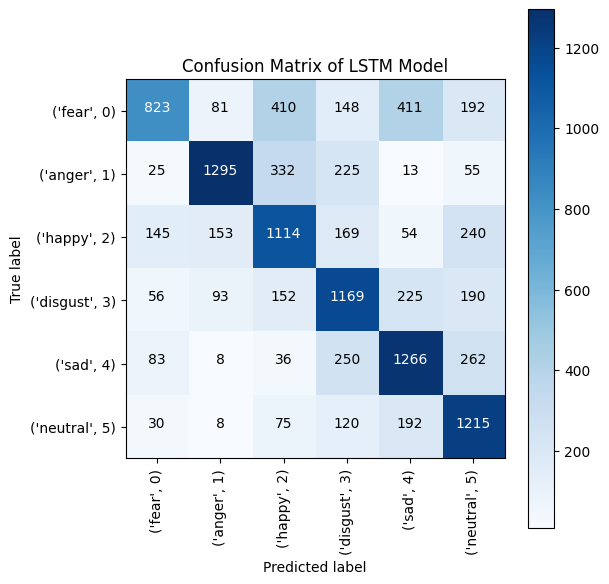

In [105]:
plot_confusion_matrix(cm, classes = list(emotion_class.items()), normalize=False, title='Confusion Matrix of LSTM Model')

### 6.2.2. AUC ROC

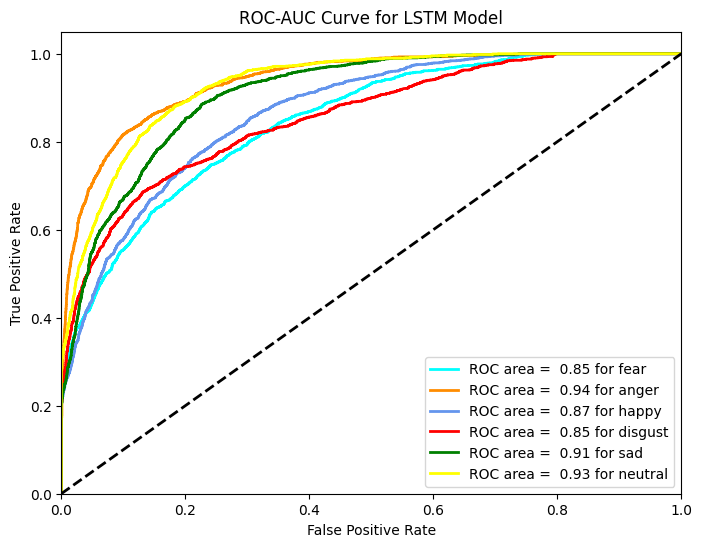

In [106]:
auc_roc_plot(y_true, y_pred_prob, 'LSTM')

# 7. LeNet-5

In [107]:
def make_lenet_model(input_shape, num_classes):
    input_layer = keras.layers.Input(input_shape)
    
    conv1 = keras.layers.Conv1D(6, kernel_size = 5)(input_layer)
    pool1 = keras.layers.MaxPooling1D(pool_size=2, strides=2)(conv1)
    
    conv2 = keras.layers.Conv1D(16, kernel_size = 5)(pool1)
    pool2 = keras.layers.MaxPooling1D(pool_size=2, strides=2)(conv2)
    
    flatten = keras.layers.Flatten()(pool2)
    dense1 = keras.layers.Dense(120, activation='relu')(flatten)
    dense2 = keras.layers.Dense(84, activation='relu')(dense1)

    output_layer = keras.layers.Dense(num_classes, activation="softmax")(dense2)

    return keras.models.Model(inputs=input_layer, outputs=output_layer)

In [108]:
lenet_model = make_lenet_model((n_row, n_col), n_class)

lenet_model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 130, 73)]         0         
                                                                 
 conv1d_13 (Conv1D)          (None, 126, 6)            2196      
                                                                 
 max_pooling1d_5 (MaxPoolin  (None, 63, 6)             0         
 g1D)                                                            
                                                                 
 conv1d_14 (Conv1D)          (None, 59, 16)            496       
                                                                 
 max_pooling1d_6 (MaxPoolin  (None, 29, 16)            0         
 g1D)                                                            
                                                                 
 flatten_1 (Flatten)         (None, 464)               0   

In [109]:
METRICS = [
    keras.metrics.CategoricalAccuracy(name = 'acc'),
    keras.metrics.Precision(name = 'prec'),
    keras.metrics.Recall(name = 'recall'),
    keras.metrics.AUC(name = 'AUC'),
    keras.metrics.F1Score(name = 'F1'),
]

In [110]:
lenet_model.compile(
      optimizer=keras.optimizers.Adam(learning_rate=0.001),
      loss=tf.keras.losses.CategoricalCrossentropy(),
      metrics=METRICS
)

In [111]:
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath=os.path.join('weights', 'best_model.h5'),
    monitor='val_loss',
    save_best_only=True,
    mode='min'
)

In [112]:
lenet_model.evaluate(test_ds, verbose=1)

89/89 [==============================] - 7s 66ms/step - loss: 1015.6547 - acc: 0.1788 - prec: 0.1788 - recall: 0.1788 - AUC: 0.5070 - F1: 0.0775


2023-11-09 01:13:06.198381: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous recv item cancelled. Key hash: 18355492285493422628
2023-11-09 01:13:06.198422: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous recv item cancelled. Key hash: 10228949760270140134


[1015.6547241210938,
 0.17878921329975128,
 0.17878921329975128,
 0.17878921329975128,
 0.5070180296897888,
 array([0.01000455, 0.13844457, 0.00523286, 0.30923837, 0.00104877,
        0.00121729], dtype=float32)]

In [113]:
# hist = lenet_model.fit(train_ds, epochs=100, verbose=1, validation_data=val_ds, callbacks=[checkpoint])

## 7.1. Model Saving

In [114]:
save_link = os.path.join('saved_model', 'lenet5.keras')
# lenet_model.save(save_link)

In [115]:
lenet_model = tf.keras.models.load_model(save_link)

In [116]:
result = lenet_model.evaluate(test_ds)

89/89 [==============================] - 6s 66ms/step - loss: 1.2332 - acc: 0.5141 - prec: 0.7346 - recall: 0.3144 - AUC: 0.8413 - F1: 0.5163


2023-11-09 01:13:12.726328: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous recv item cancelled. Key hash: 18355492285493422628
2023-11-09 01:13:12.726365: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous recv item cancelled. Key hash: 10228949760270140134


## 7.2. Plots

In [117]:
y_true_list = []
y_pred_list = []

for batch in test_ds:
    x_batch, y_batch = batch

    y_pred_batch = lenet_model.predict(x_batch)

    y_true_list.append(y_batch)
    y_pred_list.append(y_pred_batch)

y_true = np.concatenate(y_true_list, axis=0)
y_pred_prob = np.concatenate(y_pred_list, axis=0)

2/2 [==============================] - 0s 57ms/step


In [118]:
get_metric_results(result)

Loss is :  1.233
Categorical Accuracy is :  0.514
Precision score is :  0.735
Recall score is :  0.314
ROC AUC Score is :  0.841
F1 Score is : [0.4028462  0.61409396 0.48300916 0.5020855  0.56366086 0.5318611 ]


In [119]:
print('\nClassification Report:\n\n', metrics.classification_report(np.argmax(y_true, axis=1), np.argmax(y_pred_prob, axis=1)))


Classification Report:

               precision    recall  f1-score   support

           0       0.46      0.36      0.40      2065
           1       0.67      0.56      0.61      1945
           2       0.40      0.60      0.48      1875
           3       0.49      0.51      0.50      1885
           4       0.58      0.55      0.56      1905
           5       0.55      0.51      0.53      1640

    accuracy                           0.51     11315
   macro avg       0.53      0.52      0.52     11315
weighted avg       0.53      0.51      0.51     11315



### 7.2.1. Confusion Matrix

In [120]:
from sklearn.metrics import confusion_matrix, classification_report

cm = confusion_matrix(np.argmax(y_true, axis=1), np.argmax(y_pred_prob, axis=1))
cm

array([[ 736,  181,  514,  201,  272,  161],
       [  46, 1098,  545,  186,   12,   58],
       [ 137,  189, 1130,  190,   57,  172],
       [ 204,  130,  228,  963,  240,  120],
       [ 270,   17,  141,  254, 1047,  176],
       [ 196,   16,  246,  157,  182,  843]])

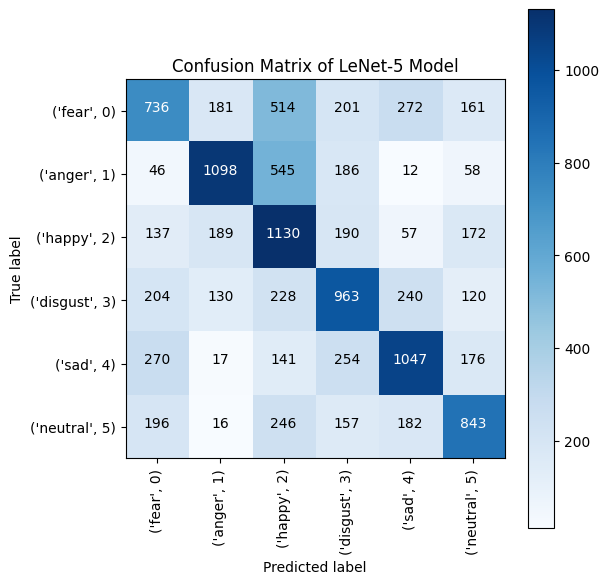

In [121]:
plot_confusion_matrix(cm, classes = list(emotion_class.items()), normalize=False, title='Confusion Matrix of LeNet-5 Model')

### 7.2.2. AUC-ROC

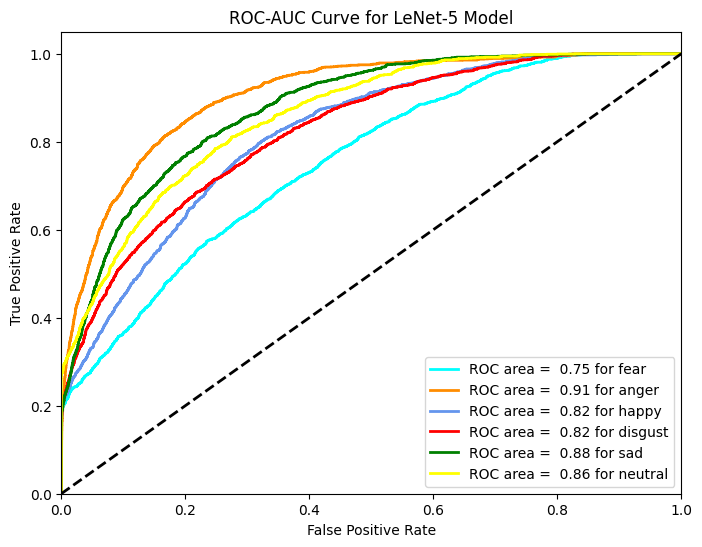

In [122]:
auc_roc_plot(y_true, y_pred_prob, 'LeNet-5')

# 8. AlexNet

In [123]:
def make_alex_model(input_shape, num_classes):
    input_layer = keras.layers.Input(input_shape)
    
    conv1 = keras.layers.Conv1D(96, kernel_size = 11, strides=4)(input_layer)
    pool1 = keras.layers.MaxPooling1D(pool_size=3, strides=2)(conv1)
    
    conv2 = keras.layers.Conv1D(256, kernel_size = 5, padding='same')(pool1)
    pool2 = keras.layers.MaxPooling1D(pool_size=3, strides=2)(conv2)
    
    conv3 = keras.layers.Conv1D(384, kernel_size = 3, padding='same')(pool2)    
    conv4 = keras.layers.Conv1D(384, kernel_size = 5, padding='same')(conv3)
    conv5 = keras.layers.Conv1D(256, kernel_size = 3, padding='same')(conv4)    
    pool3 = keras.layers.MaxPooling1D(pool_size=3, strides=2)(conv5)
    
    flatten = keras.layers.Flatten()(pool3)
    dense1 = keras.layers.Dense(4096, activation='relu')(flatten)
    drop1 = keras.layers.Dropout(0.5)(dense1)
    dense2 = keras.layers.Dense(4096, activation='relu')(drop1)
    drop2 = keras.layers.Dropout(0.5)(dense2)

    output_layer = keras.layers.Dense(num_classes, activation="softmax")(drop2)

    return keras.models.Model(inputs=input_layer, outputs=output_layer)

In [124]:
alexnet_model = make_alex_model((n_row, n_col), n_class)

alexnet_model.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 130, 73)]         0         
                                                                 
 conv1d_15 (Conv1D)          (None, 30, 96)            77184     
                                                                 
 max_pooling1d_7 (MaxPoolin  (None, 14, 96)            0         
 g1D)                                                            
                                                                 
 conv1d_16 (Conv1D)          (None, 14, 256)           123136    
                                                                 
 max_pooling1d_8 (MaxPoolin  (None, 6, 256)            0         
 g1D)                                                            
                                                                 
 conv1d_17 (Conv1D)          (None, 6, 384)            2952

In [125]:
METRICS = [
    keras.metrics.CategoricalAccuracy(name = 'acc'),
    keras.metrics.Precision(name = 'prec'),
    keras.metrics.Recall(name = 'recall'),
    keras.metrics.AUC(name = 'AUC'),
    keras.metrics.F1Score(name = 'F1'),
]

In [126]:
alexnet_model.compile(
      optimizer=keras.optimizers.Adam(learning_rate=0.001),
      loss=tf.keras.losses.CategoricalCrossentropy(),
      metrics=METRICS
)

In [127]:
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath=os.path.join('weights', 'best_model.h5'),
    monitor='val_loss',
    save_best_only=True,
    mode='min'
)

In [128]:
alexnet_model.evaluate(test_ds, verbose=1)

89/89 [==============================] - 6s 65ms/step - loss: 350.1046 - acc: 0.1825 - prec: 0.1825 - recall: 0.1825 - AUC: 0.5095 - F1: 0.0514


[350.1046447753906,
 0.18250110745429993,
 0.18250110745429993,
 0.18250110745429993,
 0.5095006823539734,
 array([0.30866966, 0.        , 0.        , 0.        , 0.        ,
        0.        ], dtype=float32)]

In [129]:
# hist = alexnet_model.fit(train_ds, epochs=100, verbose=1, validation_data=val_ds, callbacks=[checkpoint])

## 8.1. Model Saving

In [130]:
save_link = os.path.join('saved_model', 'alexnet.keras')
# alexnet_model.save(save_link)

In [131]:
alexnet_model = tf.keras.models.load_model(save_link)

In [132]:
result = alexnet_model.evaluate(test_ds)

89/89 [==============================] - 6s 65ms/step - loss: 1.1173 - acc: 0.5617 - prec: 0.7777 - recall: 0.3565 - AUC: 0.8723 - F1: 0.5593


2023-11-09 01:13:38.807221: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous recv item cancelled. Key hash: 13784928364000856287
2023-11-09 01:13:38.807254: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous recv item cancelled. Key hash: 3930775325748304219
2023-11-09 01:13:38.807273: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous recv item cancelled. Key hash: 17475275521729090148


## 8.2. Plots

In [133]:
y_true_list = []
y_pred_list = []

for batch in test_ds:
    x_batch, y_batch = batch

    y_pred_batch = alexnet_model.predict(x_batch)

    y_true_list.append(y_batch)
    y_pred_list.append(y_pred_batch)

y_true = np.concatenate(y_true_list, axis=0)
y_pred_prob = np.concatenate(y_pred_list, axis=0)

2/2 [==============================] - 0s 158ms/step


In [134]:
get_metric_results(result)

Loss is :  1.117
Categorical Accuracy is :  0.562
Precision score is :  0.778
Recall score is :  0.357
ROC AUC Score is :  0.872
F1 Score is : [0.47194165 0.65177083 0.5335263  0.5424141  0.5829433  0.5729458 ]


In [135]:
print('Classification Report:\n')
print(metrics.classification_report(np.argmax(y_true, axis=1), np.argmax(y_pred_prob, axis=1)))

Classification Report:

              precision    recall  f1-score   support

           0       0.56      0.41      0.47      2065
           1       0.61      0.70      0.65      1945
           2       0.49      0.59      0.53      1875
           3       0.64      0.47      0.54      1885
           4       0.58      0.59      0.58      1905
           5       0.53      0.62      0.57      1640

    accuracy                           0.56     11315
   macro avg       0.57      0.56      0.56     11315
weighted avg       0.57      0.56      0.56     11315



### 8.2.1. Confusion Matrix

In [136]:
from sklearn.metrics import confusion_matrix, classification_report

cm = confusion_matrix(np.argmax(y_true, axis=1), np.argmax(y_pred_prob, axis=1))

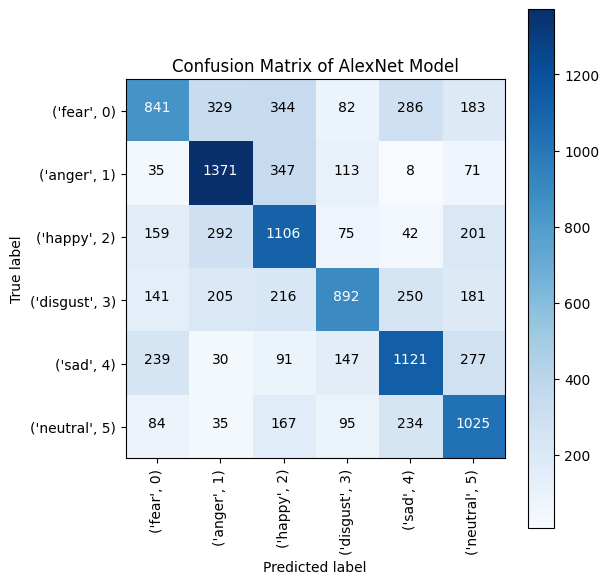

In [137]:
plot_confusion_matrix(
    cm, 
    classes = list(emotion_class.items()), 
    normalize=False, 
    title='Confusion Matrix of AlexNet Model'
)

### 8.2.2. AUC-ROC

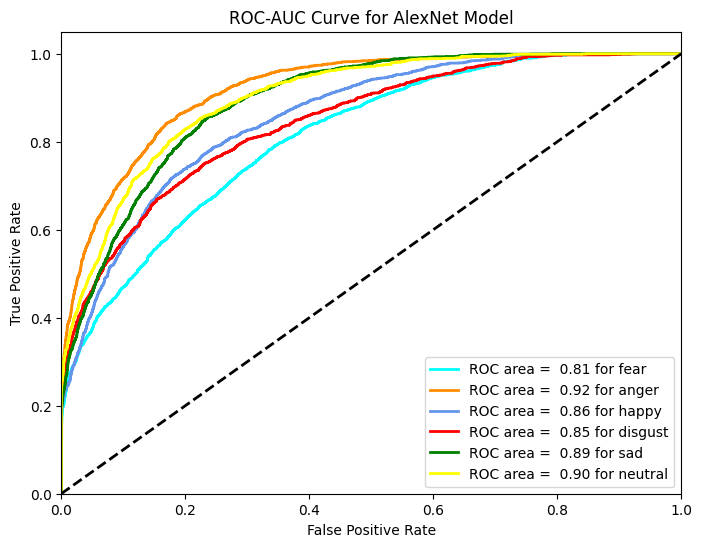

In [138]:
auc_roc_plot(y_true, y_pred_prob, 'AlexNet')